In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matgraphdb import GraphGenerator
from matgraphdb.mlcore.transforms import min_max_normalize, standardize_tensor
main_graph_dir = GraphGenerator().main_graph_dir
main_nodes_dir = os.path.join(main_graph_dir,'nodes') 

In [2]:
element_node_path=os.path.join(main_nodes_dir,'element.csv')
chemenv_node_path=os.path.join(main_nodes_dir,'chemenv.csv')
material_node_path=os.path.join(main_nodes_dir,'material.csv')

element_df=pd.read_csv(element_node_path,index_col=0)
chemenv_df=pd.read_csv(chemenv_node_path,index_col=0)
material_df=pd.read_csv(material_node_path,index_col=0)

In [4]:
from matgraphdb.mlcore.encoders import ListIdentityEncoder, IdentityEncoder
import torch


In [94]:
identity_list_encoder=ListIdentityEncoder(dtype=torch.float32,normalize=True)
identity_encoder=IdentityEncoder(dtype=torch.float32,normalize=False)
identity_normalized_encoder=IdentityEncoder(dtype=torch.float32,normalize=True)

y=identity_encoder(material_df['k_vrh:float'])

# X=torch.empty((len(material_df),1))

tmp_x=identity_list_encoder(material_df['element_property:float[]'])
# tmp_x=identity_normalized_encoder(material_df['element_property:float[]'])
# X=torch.cat((X,tmp_x),axis=1)
X=tmp_x
# print(X.shape)
# X=identity_list_encoder(material_df['sine_coulomb_matrix:float[]'])

print(X.shape)
print(y.shape)
print(y[:10])

torch.Size([80636, 132])
torch.Size([80636, 1])
tensor([[    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [12.6240],
        [    nan]])


In [95]:
# Create mask for non-NaN values in y
mask = ~torch.isnan(y)[:,0]

# # Apply mask to both X and y
X_filtered = X[mask,:]
y_filtered = y[mask,:]

print(X_filtered.shape)
print(y_filtered.shape)


torch.Size([10166, 132])
torch.Size([10166, 1])


In [96]:
def create_range_mask(y, min_value, max_value):
    """
    Create a mask for values within the specified range (inclusive).
    """
    return (y >= min_value) & (y <= max_value)

mask = create_range_mask(y_filtered, min_value=0, max_value=200)[:,0]
y_filtered = y_filtered[mask]
X_filtered= X_filtered[mask]

print(X_filtered.shape)
print(y_filtered.shape)

torch.Size([9149, 132])
torch.Size([9149, 1])


In [97]:
print(y_filtered[:100])

tensor([[ 12.6240],
        [189.9630],
        [ 43.8170],
        [ 35.0300],
        [ 98.7000],
        [ 59.4260],
        [ 20.3330],
        [ 72.2160],
        [103.9690],
        [ 77.5510],
        [ 30.0090],
        [ 40.5130],
        [142.0570],
        [ 56.1160],
        [ 73.5700],
        [ 55.7900],
        [ 71.7210],
        [ 38.1080],
        [ 99.6110],
        [147.0390],
        [ 86.8260],
        [182.5680],
        [ 39.5160],
        [ 36.7760],
        [183.5420],
        [ 88.3100],
        [101.6640],
        [ 38.3210],
        [ 70.2980],
        [ 40.0130],
        [153.8340],
        [ 90.8830],
        [173.1910],
        [ 21.8870],
        [143.6060],
        [188.6560],
        [ 27.9410],
        [ 86.8460],
        [146.2200],
        [ 88.8360],
        [ 69.3360],
        [170.1900],
        [ 77.8670],
        [100.6250],
        [ 56.4530],
        [ 77.3360],
        [ 54.5970],
        [161.0870],
        [194.2130],
        [ 56.0840],


Count: 9149.0000
Mean: 84.3845
Median: 75.3440
Standard Deviation: 52.5081
Minimum: 0.1130
Maximum: 199.9490
25th Percentile: 41.4470
75th Percentile: 124.0600
Skewness: 0.4383
Kurtosis: -0.8486
Range: 199.8360
Interquartile Range (IQR): 82.6130


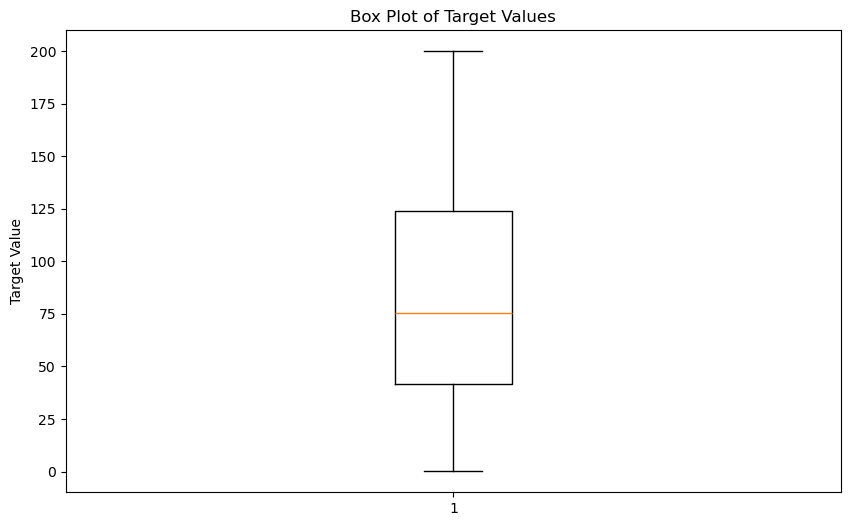

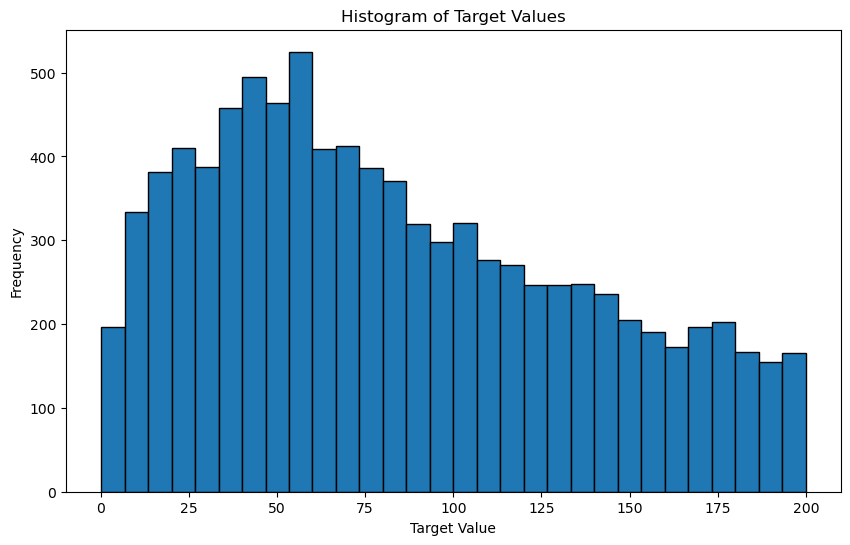

In [98]:
import numpy as np
import pandas as pd

# Assuming y_filtered is your target variable tensor
# Convert to numpy array for easier manipulation
y_np = y_filtered.numpy()[:,0]

# Create a pandas Series for easy statistical calculations
y_series = pd.Series(y_np)

# Calculate statistics
stats = {
    "Count": y_series.count(),
    "Mean": y_series.mean(),
    "Median": y_series.median(),
    "Standard Deviation": y_series.std(),
    "Minimum": y_series.min(),
    "Maximum": y_series.max(),
    "25th Percentile": y_series.quantile(0.25),
    "75th Percentile": y_series.quantile(0.75),
    "Skewness": y_series.skew(),
    "Kurtosis": y_series.kurtosis()
}

# Print the statistics
for stat, value in stats.items():
    print(f"{stat}: {value:.4f}")

# Calculate and print the range
value_range = stats["Maximum"] - stats["Minimum"]
print(f"Range: {value_range:.4f}")

# Calculate and print the Interquartile Range (IQR)
iqr = stats["75th Percentile"] - stats["25th Percentile"]
print(f"Interquartile Range (IQR): {iqr:.4f}")

# Optionally, create a box plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(y_np)
plt.title("Box Plot of Target Values")
plt.ylabel("Target Value")
plt.show()

# Optionally, create a histogram
plt.figure(figsize=(10, 6))
plt.hist(y_np, bins=30, edgecolor='black')
plt.title("Histogram of Target Values")
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.show()

In [99]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch

from sklearn.preprocessing import StandardScaler,MinMaxScaler

# First, split into train+val and test sets (80% train+val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Then split train+val into train and validation sets (75% train, 25% val)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


# scaler = MinMaxScaler()
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)
# X_test_scaled = scaler.transform(X_test)
# # Convert back to PyTorch tensors
# X_train_scaled = torch.FloatTensor(X_train_scaled)
# X_val_scaled = torch.FloatTensor(X_val_scaled)
# X_test_scaled = torch.FloatTensor(X_test_scaled)

# # Create DataLoaders with scaled data
# batch_size = 32
# train_loader = DataLoader(TensorDataset(X_train_scaled, y_train), batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(TensorDataset(X_val_scaled, y_val), batch_size=batch_size)
# test_loader = DataLoader(TensorDataset(X_test_scaled, y_test), batch_size=batch_size)

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Define batch size
batch_size = 64  # You can adjust this value as needed

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [102]:
from matgraphdb.mlcore.models import MultiLayerPerceptron
import torch.nn as nn
import torch.optim as optim

# Define the model
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.LeakyReLU()
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x.squeeze()

# Initialize the model
input_dim = X_train.shape[1]
model = MultiLayerPerceptron(input_dim, output_dim=1, num_layers=3, n_embd=32)
# model = RegressionModel(input_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

MultiLayerPerceptron(
  (input_layer): InputLayer(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (proj): Linear(in_features=132, out_features=32, bias=True)
  )
  (layers): ModuleList(
    (0-2): 3 x FeedFoward(
      (net): Sequential(
        (0): Linear(in_features=32, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=32, bias=True)
        (3): Dropout(p=0.2, inplace=False)
      )
      (ln): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
  )
  (ln_f): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)


In [103]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss/len(train_loader):.4f}, '
          f'Val Loss: {val_loss/len(val_loader):.4f}')

# Test the model
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}')

Epoch [1/100], Train Loss: 9069.7660, Val Loss: 9144.3006
Epoch [2/100], Train Loss: 8419.7686, Val Loss: 8315.7292
Epoch [3/100], Train Loss: 7574.0428, Val Loss: 7282.5197
Epoch [4/100], Train Loss: 6585.2467, Val Loss: 6166.1263
Epoch [5/100], Train Loss: 5581.5933, Val Loss: 5116.3887
Epoch [6/100], Train Loss: 4676.1301, Val Loss: 4239.0803
Epoch [7/100], Train Loss: 3934.9903, Val Loss: 3583.4488
Epoch [8/100], Train Loss: 3415.5337, Val Loss: 3159.0622
Epoch [9/100], Train Loss: 3080.7901, Val Loss: 2922.3484
Epoch [10/100], Train Loss: 2906.6718, Val Loss: 2814.3574
Epoch [11/100], Train Loss: 2807.6049, Val Loss: 2776.7083
Epoch [12/100], Train Loss: 2776.2472, Val Loss: 2768.3241
Epoch [13/100], Train Loss: 2760.5875, Val Loss: 2770.4903
Epoch [14/100], Train Loss: 2760.0593, Val Loss: 2773.3459
Epoch [15/100], Train Loss: 2761.1003, Val Loss: 2770.9121
Epoch [16/100], Train Loss: 2770.8202, Val Loss: 2601.1347
Epoch [17/100], Train Loss: 2596.3403, Val Loss: 2570.4635
Epoch 

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()

lr.fit(X_train, y_train)


# get fit statistics
print ('R2 = ' + str(round(lr.score(X_test, y_test), 3)))
print ('RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y_test, y_pred=lr.predict(X_test))))

R2 = -0.347
RMSE = 60.913
